In [65]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers, models, datasets, backend
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
with tf.device("/gpu:0"):
    np.random.seed(3)
    tf.random.set_seed(3)

In [66]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [67]:
tf.__version__

'2.7.0'

In [68]:
x_train = train.drop('label', axis=1, inplace=False)
y_train = train['label']

In [69]:
x_train = x_train.values.reshape(-1, 28, 28, 1)
y_train = y_train.values.reshape(-1, 1)

In [70]:
x_test = test
x_test = x_test.values.reshape(-1, 28, 28, 1)

In [71]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

[0]


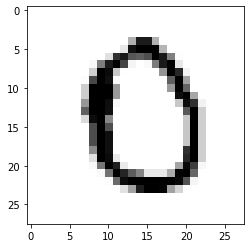

In [72]:
plt.imshow(x_train[5], cmap='Greys', interpolation='None')
print(y_train[5])

In [73]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0


In [74]:
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)


In [75]:
y_train[5]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [76]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 32)        51232     
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [78]:
batch_size = 100
epochs = 100

In [79]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
)

In [80]:
model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
)

In [81]:
callbacks = [EarlyStopping(monitor='accuracy', patience=3)]
history = model.fit(
                train_datagen.flow(x_train, y_train, batch_size=batch_size),
                steps_per_epoch=100,
                epochs=epochs,
                validation_data=(x_val, y_val),
                verbose=1,
                callbacks=callbacks
                )

Epoch 1/100
100/100 [==============================] - 16s 158ms/step - loss: 0.9842 - accuracy: 0.6625 - val_loss: 0.1354 - val_accuracy: 0.9569
Epoch 2/100
100/100 [==============================] - 16s 155ms/step - loss: 0.2823 - accuracy: 0.9122 - val_loss: 0.1010 - val_accuracy: 0.9681
Epoch 3/100
100/100 [==============================] - 16s 158ms/step - loss: 0.2076 - accuracy: 0.9366 - val_loss: 0.0705 - val_accuracy: 0.9790
Epoch 4/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1693 - accuracy: 0.9493 - val_loss: 0.0652 - val_accuracy: 0.9805
Epoch 5/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1357 - accuracy: 0.9581 - val_loss: 0.0509 - val_accuracy: 0.9819
Epoch 6/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1352 - accuracy: 0.9598 - val_loss: 0.0517 - val_accuracy: 0.9845
Epoch 7/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1206 - accuracy: 0.9637 - val_loss: 0.0458 -

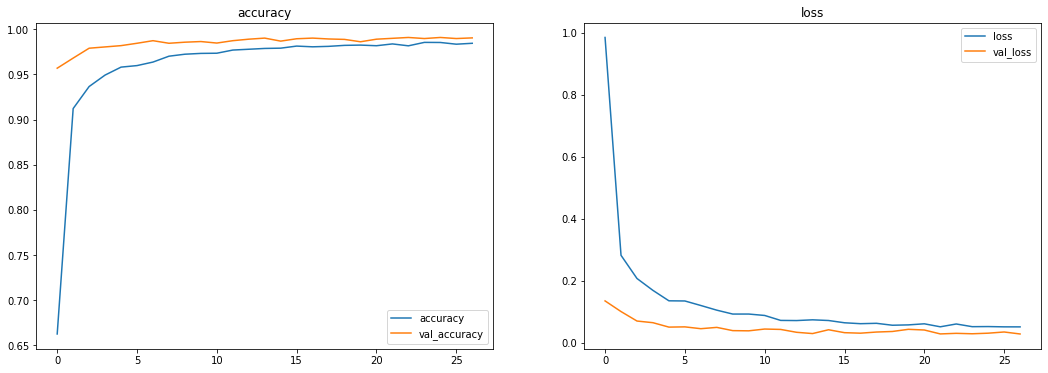

In [82]:
plt.figure(figsize=(18, 6))

# 에포크별 정확도
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("accuracy")
plt.legend()

# 에포크별 손실률
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("loss")
plt.legend()

plt.show()

In [83]:
result = model.predict(x_test)

In [84]:
result = np.argmax(result,axis=1)

In [88]:
result

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [89]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Label'] = result
submission.to_csv('final_submission.csv', index=False)